1. Get historical stock prices
2. Set the simulation length (90 days, perhaps)
3. Run the simulation (below)

For each simulation length:
    For each day:
        1. Run the simulation to understand the upside ratio based on the price that day
        2. "Buy" the stocks that are above 2 upside ratio and less than 1 width (?)
        3. "Sell" the stocks at their "expiration" 
        
        Data shape: 
        
        | buy date | symbol | buy price | expiration date | sell price | perc 5 | median | perc 95 | upside ratio | upside | downside | width
        


In [1]:
import pandas as pd
import math
import requests
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import genextreme
from random import choices
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

%matplotlib inline

# Get Historical Stock Prices

In [90]:
def get_token(path_to_config = './'):
    config = pd.read_csv(f'{path_to_config}sandbox.config')
    token = config['prod_token'].iloc[0]

    return(token)

def get_hist_data(symbol,
                  token,
                  start = '2000-01-01',
                  end = datetime.today().date().isoformat(),
                  endpoint = 'https://api.tradier.com',
                  path = '/v1/markets/history'):

    response = requests.get(f'{endpoint}{path}',
        params = {'symbol':f'{symbol}',
                  'interval': 'daily',
                  'start': '2000-01-01',
                  'end': f'{datetime.today().date().isoformat()}'},
        headers = {'Authorization': f'Bearer {token}',
                   'Accept': 'application/json'})
    json_response = response.json()
    
    if json_response['history'] == None:
        return(-1)
    
    hist_price = pd.json_normalize(json_response['history']['day'])
    hist_price = hist_price.rename(({'date': 'Date',
                                     'open': 'Open',
                                     'close': 'Close'}),
                                    axis = 'columns')
    hist_price['Open'] = hist_price['Open'].astype('float64')
    hist_price['Close'] = hist_price['Close'].astype('float64')
    hist_price['perc_change'] = ((hist_price['Close'] - hist_price['Open']) /
                                    hist_price['Open'])
    hist_price['symbol'] = symbol

    return(hist_price)

def get_stock_table(url = 'https://iocalc.com/api:gPr_YnZX/getstocks'):
    response = requests.get(url)

    stock_table = pd.json_normalize(response.json()['stocks'])

    return(stock_table)


In [91]:
token = get_token('../tradier_exploration/')
stock_table = get_stock_table()

In [92]:
small_stocks = stock_table.sort_values('price').head(10)

In [93]:


all_stock_data = pd.DataFrame()

for symbol in stock_table['symbol']:
    hist_price = get_hist_data(symbol, token)
    
    if type(hist_price) != int:
        all_stock_data = pd.concat([all_stock_data, hist_price], 
                                   axis = 0, 
                                   ignore_index = True)

all_stock_data

,Date,Open,high,low,Close,volume,perc_change,symbol
0,2000-07-03,50.6250,55.125,50.625,55.0000,3308200,0.086420,VZ
1,2000-07-05,55.7500,56.875,54.125,54.4375,5826300,-0.023543,VZ
2,2000-07-06,54.5000,56.1875,53.5,53.8125,3755000,-0.012615,VZ
3,2000-07-07,54.0625,56.0,54.0625,55.3750,4102000,0.024277,VZ
4,2000-07-10,55.0000,55.625,54.5625,54.6875,3850300,-0.005682,VZ
...,...,...,...,...,...,...,...,...
256791,2022-12-06,5.9600,6.105,5.73,5.8400,5901336,-0.020134,KOS
256792,2022-12-07,5.9200,6.02,5.76,5.8700,4841592,-0.008446,KOS
256793,2022-12-08,6.0900,6.115,5.7,5.7500,5091492,-0.055829,KOS
256794,2022-12-09,5.7750,5.8288,5.5,5.5000,4881684,-0.047619,KOS


# Set the Simulation Length

In [94]:
nyse = mcal.get_calendar('NYSE')

today = datetime.today().date()

sim_start_date = today - timedelta(days = 360)
sim_end_date = today - timedelta(days = 1)
early = nyse.schedule(start_date = sim_start_date.isoformat(), 
                      end_date = sim_end_date.isoformat())

date = {"Date": early.index}

dates = pd.DataFrame(data = date)
dates



,Date
0,2021-12-17
1,2021-12-20
2,2021-12-21
3,2021-12-22
4,2021-12-23
...,...
242,2022-12-05
243,2022-12-06
244,2022-12-07
245,2022-12-08


# Run the simulation for each day

In [95]:
def get_simulation(symbol,
                   finish_date,
                   hist_price,
                   today,
                   start_price,
                   num_samples = 10000,
                   sample_size = 20000,
                   upper_scale = 0.60,
                   upper_shape = -0.09,
                   lower_scale = 0.65,
                   lower_shape = -0.1,
                   max_range = 0.30,
                   lookback = 3):

    
    early = nyse.schedule(start_date = today.isoformat(), 
                          end_date = finish_date)

    date = {"Date": early.index}

    dates = pd.DataFrame(data = date)

    num_trading_days = int(round(dates.shape[0] * lookback, 0))

    start = today - timedelta(days = num_trading_days)
    start = start.isoformat()
    
    if type(hist_price) is int:
        return(-1, -1, -1)
    
    perc_pos_ = (
        sum(hist_price.loc[hist_price['Date'] > start, 'perc_change'] > 0) /
        len(hist_price.loc[hist_price['Date'] > start, 'perc_change'])
    )
    
    perc_neg_ = 1 - perc_pos_
    
    perc_pos = 0.5 + ((max_range / 2) * perc_pos_)
    perc_neg = 0.5 - ((max_range / 2) * perc_neg_)

    avg = np.mean(hist_price['perc_change'])
    std = np.std(hist_price['perc_change'])

    samp_upper = genextreme.rvs(upper_shape,
                                loc = avg,
                                scale = upper_scale * std,
                                size = round(sample_size * perc_pos))

    samp_lower = -1 * genextreme.rvs(lower_shape,
                                     loc = avg,
                                     scale = lower_scale * std,
                                     size = round(sample_size * perc_neg))

    samp = np.append(samp_upper, samp_lower)
    del samp_upper, samp_lower

    sample_col = pd.Series(range(1, num_trading_days + 1)).repeat(num_samples)
    dates_col = dates['Date'].repeat(num_samples)
    sample_values = np.array(choices(samp + 1,
                                     k = num_samples * num_trading_days
                                     )).reshape(num_trading_days,
                                                num_samples)

    sample_values[0] = start_price

    price_paths = sample_values.cumprod(axis = 0)

    final_prices = price_paths[num_trading_days - 1]
    del price_paths

    prob_below = sum(final_prices < start_price) / num_samples
    quantiles = np.quantile(final_prices, (0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0))

    return(prob_below, quantiles, start_price)

def get_date(num_days,
             today = datetime.today().date(),
             max_days = 90):
    finish_date = today + timedelta(days = max_days * 4)
    early = nyse.schedule(start_date = today.isoformat(), 
                          end_date = finish_date.isoformat())

    date = {"Date": early.index}
    dates = pd.DataFrame(data = date)
    
    sim_end_date = dates['Date'].iloc[num_days]
    
    return(sim_end_date.isoformat())

def create_data(start_date,
                all_stock_data,
                days = [5, 10, 15, 20, 30, 60, 90]):

    prob_change = pd.DataFrame()

    for symbol in stock_table['symbol']:
        
        hist_price = all_stock_data[(all_stock_data['symbol'] == symbol) & 
                                     (all_stock_data['Date'] < start_date.isoformat())]
        
        if hist_price.shape[0] == 0:
            continue
        
        start_price = all_stock_data['Close'].loc[(all_stock_data['symbol'] == symbol) & 
                                                   (all_stock_data['Date'] == start_date.isoformat())].item()
        
        for num_days in days:
            end_date = get_date(num_days, start_date)
            prob_below_current, quantile, current_price = get_simulation(symbol, 
                                                                         end_date,
                                                                         hist_price,
                                                                         start_date,
                                                                         start_price)
            
            if prob_below_current == -1:
                continue

            tmp = pd.DataFrame({'symbol': symbol,
                                'sim_length': num_days,
                                'sim_end_date': end_date,
                                'current_price': current_price,
                                'prob_below_current': prob_below_current,
                                'min_sim_price': quantile[0],
                                'percentile_5': quantile[1],
                                'percentile_10': quantile[2],
                                'percentile_25': quantile[3],
                                'median_sim_price': quantile[4],
                                'percentile_75': quantile[5],
                                'percentile_90': quantile[6],
                                'percentile_95': quantile[7],
                                'max_sim_price': quantile[8]},
                              index = [0])

            prob_change = pd.concat([prob_change, tmp], axis = 0, ignore_index = True)

    return(prob_change)


In [96]:
all_prob_change_data = pd.DataFrame()

for day in dates['Date']:
    day = day.date()
    
    prob_change = create_data(day,
                              all_stock_data,
                              days = [30])
    prob_change['sim_start_date'] = day
    
    all_prob_change_data = pd.concat([all_prob_change_data, prob_change],
                                     axis = 0,
                                     ignore_index = True)

all_prob_change_data

,symbol,sim_length,sim_end_date,current_price,prob_below_current,min_sim_price,percentile_5,percentile_10,percentile_25,median_sim_price,percentile_75,percentile_90,percentile_95,max_sim_price,sim_start_date
0,VZ,30,2022-02-01T00:00:00,53.17,0.3531,34.322635,45.041471,47.390985,51.209551,55.657134,60.540782,65.550732,68.459843,90.464610,2021-12-17
1,DAL,30,2022-02-01T00:00:00,36.56,0.3580,11.764097,25.498285,28.281744,33.465715,40.452811,48.462263,57.094746,62.825215,166.167476,2021-12-17
2,CASH,30,2022-02-01T00:00:00,56.27,0.3781,21.661457,39.280690,43.449401,50.957558,61.156208,72.824286,85.224748,93.356732,186.715892,2021-12-17
3,HUM,30,2022-02-01T00:00:00,453.33,0.3918,206.016185,331.857201,360.386445,414.171886,484.151777,562.427863,640.287836,688.108637,1068.111672,2021-12-17
4,QYLD,30,2022-02-01T00:00:00,22.19,0.4199,17.037874,20.029689,20.527463,21.459744,22.482024,23.590330,24.596537,25.223526,30.080590,2021-12-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,OII,30,2023-01-25T00:00:00,13.43,0.3352,4.970349,9.473516,10.543835,12.576293,15.144831,18.233665,21.456867,23.711163,52.831299,2022-12-09
17286,GFS,30,2023-01-25T00:00:00,63.42,0.4045,14.326542,36.180472,41.999480,53.664941,69.622660,90.421892,114.320209,131.188881,360.754793,2022-12-09
17287,SBIO,30,2023-01-25T00:00:00,29.07,0.4187,13.842565,21.968177,23.615294,26.605130,30.294470,34.469804,38.637303,41.475356,65.679449,2022-12-09
17288,RKLB,30,2023-01-25T00:00:00,4.00,0.4684,0.849723,2.185565,2.510845,3.184944,4.117540,5.241446,6.486019,7.368051,17.077053,2022-12-09


# Now... does the simulation actually simulate? 

In [97]:
all_prob_change_data['sim_end_date'] = pd.to_datetime(all_prob_change_data['sim_end_date'], format = '%Y-%m-%dT00:00:00')

In [98]:
all_stock_data['sim_end_price'] = all_stock_data['Close']
all_stock_data['Date'] = pd.to_datetime(all_stock_data['Date'], format = '%Y-%m-%d')
end_price = all_stock_data[['Date', 'sim_end_price', 'symbol']]
end_price.dtypes

Date             datetime64[ns]
sim_end_price           float64
symbol                   object
dtype: object

In [99]:
all_prob_change_data_2 = pd.merge(all_prob_change_data, 
                                  end_price, 
                                  how = 'left',
                                  left_on = ['sim_end_date', 'symbol'],
                                  right_on = ['Date', 'symbol'])

all_prob_change_data_2

,symbol,sim_length,sim_end_date,current_price,prob_below_current,min_sim_price,percentile_5,percentile_10,percentile_25,median_sim_price,percentile_75,percentile_90,percentile_95,max_sim_price,sim_start_date,Date,sim_end_price
0,VZ,30,2022-02-01,53.17,0.3531,34.322635,45.041471,47.390985,51.209551,55.657134,60.540782,65.550732,68.459843,90.464610,2021-12-17,2022-02-01,53.20
1,DAL,30,2022-02-01,36.56,0.3580,11.764097,25.498285,28.281744,33.465715,40.452811,48.462263,57.094746,62.825215,166.167476,2021-12-17,2022-02-01,40.49
2,CASH,30,2022-02-01,56.27,0.3781,21.661457,39.280690,43.449401,50.957558,61.156208,72.824286,85.224748,93.356732,186.715892,2021-12-17,2022-02-01,61.58
3,HUM,30,2022-02-01,453.33,0.3918,206.016185,331.857201,360.386445,414.171886,484.151777,562.427863,640.287836,688.108637,1068.111672,2021-12-17,2022-02-01,390.68
4,QYLD,30,2022-02-01,22.19,0.4199,17.037874,20.029689,20.527463,21.459744,22.482024,23.590330,24.596537,25.223526,30.080590,2021-12-17,2022-02-01,20.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,OII,30,2023-01-25,13.43,0.3352,4.970349,9.473516,10.543835,12.576293,15.144831,18.233665,21.456867,23.711163,52.831299,2022-12-09,NaT,NaN
17286,GFS,30,2023-01-25,63.42,0.4045,14.326542,36.180472,41.999480,53.664941,69.622660,90.421892,114.320209,131.188881,360.754793,2022-12-09,NaT,NaN
17287,SBIO,30,2023-01-25,29.07,0.4187,13.842565,21.968177,23.615294,26.605130,30.294470,34.469804,38.637303,41.475356,65.679449,2022-12-09,NaT,NaN
17288,RKLB,30,2023-01-25,4.00,0.4684,0.849723,2.185565,2.510845,3.184944,4.117540,5.241446,6.486019,7.368051,17.077053,2022-12-09,NaT,NaN


In [100]:
all_prob_change_data_2.loc[(all_prob_change_data_2['percentile_5'] <= all_prob_change_data_2['sim_end_price']) & 
                           (all_prob_change_data_2['percentile_95'] >= all_prob_change_data_2['sim_end_price']), 
                           'inside_90'] = True
all_prob_change_data_2.loc[(all_prob_change_data_2['percentile_5'] > all_prob_change_data_2['sim_end_price']) | 
                           (all_prob_change_data_2['percentile_95'] < all_prob_change_data_2['sim_end_price']), 
                           'inside_90'] = False
all_prob_change_data_2

/Users/jacobrozran/opt/anaconda3/envs/rle_finance/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/jacobrozran/opt/anaconda3/envs/rle_finance/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,symbol,sim_length,sim_end_date,current_price,prob_below_current,min_sim_price,percentile_5,percentile_10,percentile_25,median_sim_price,percentile_75,percentile_90,percentile_95,max_sim_price,sim_start_date,Date,sim_end_price,inside_90
0,VZ,30,2022-02-01,53.17,0.3531,34.322635,45.041471,47.390985,51.209551,55.657134,60.540782,65.550732,68.459843,90.464610,2021-12-17,2022-02-01,53.20,True
1,DAL,30,2022-02-01,36.56,0.3580,11.764097,25.498285,28.281744,33.465715,40.452811,48.462263,57.094746,62.825215,166.167476,2021-12-17,2022-02-01,40.49,True
2,CASH,30,2022-02-01,56.27,0.3781,21.661457,39.280690,43.449401,50.957558,61.156208,72.824286,85.224748,93.356732,186.715892,2021-12-17,2022-02-01,61.58,True
3,HUM,30,2022-02-01,453.33,0.3918,206.016185,331.857201,360.386445,414.171886,484.151777,562.427863,640.287836,688.108637,1068.111672,2021-12-17,2022-02-01,390.68,True
4,QYLD,30,2022-02-01,22.19,0.4199,17.037874,20.029689,20.527463,21.459744,22.482024,23.590330,24.596537,25.223526,30.080590,2021-12-17,2022-02-01,20.87,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,OII,30,2023-01-25,13.43,0.3352,4.970349,9.473516,10.543835,12.576293,15.144831,18.233665,21.456867,23.711163,52.831299,2022-12-09,NaT,NaN,NaN
17286,GFS,30,2023-01-25,63.42,0.4045,14.326542,36.180472,41.999480,53.664941,69.622660,90.421892,114.320209,131.188881,360.754793,2022-12-09,NaT,NaN,NaN
17287,SBIO,30,2023-01-25,29.07,0.4187,13.842565,21.968177,23.615294,26.605130,30.294470,34.469804,38.637303,41.475356,65.679449,2022-12-09,NaT,NaN,NaN
17288,RKLB,30,2023-01-25,4.00,0.4684,0.849723,2.185565,2.510845,3.184944,4.117540,5.241446,6.486019,7.368051,17.077053,2022-12-09,NaT,NaN,NaN


In [106]:
sum_dat = (
    all_prob_change_data_2
    .loc[all_prob_change_data_2['sim_end_price'].notnull()]
    .groupby(['symbol'])['inside_90'].agg([sum, len])
)
sum_dat['perc'] = sum_dat['sum'] / sum_dat['len']
sum_dat.sort_values('perc')

,sum,len,perc
symbol,,,
CVNA,147,218,0.674312
PYPL,165,218,0.756881
NEWR,168,218,0.770642
QYLD,173,218,0.793578
FIS,174,218,0.798165
NFLX,175,218,0.802752
SRVR,181,218,0.830275
MDB,185,218,0.848624
BBWI,186,218,0.853211


In [109]:
plot_dat = all_prob_change_data_2.loc[(all_prob_change_data_2['symbol'] == 'PYPL') &
                                      (all_prob_change_data_2['sim_end_price'].notnull())]


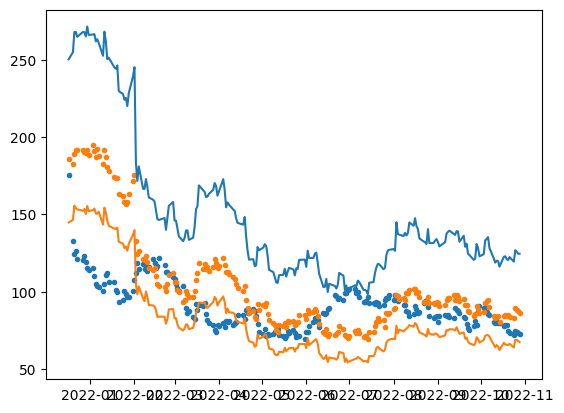

In [110]:
plt.scatter(x = plot_dat['sim_start_date'], y = plot_dat['sim_end_price'], marker = '.')
plt.scatter(x = plot_dat['sim_start_date'], y = plot_dat['current_price'], marker = '.')
plt.plot(plot_dat['sim_start_date'], plot_dat['percentile_95'])
plt.plot(plot_dat['sim_start_date'], plot_dat['percentile_5'])
plt.show();

This is the end of this right now. 

In [ ]:
all_prob_change_data['width'] = ((all_prob_change_data['percentile_95'] - 
                                  all_prob_change_data['percentile_5']) / 
                                 all_prob_change_data['current_price'])
all_prob_change_data['downside'] = ((all_prob_change_data['current_price'] - 
                                     all_prob_change_data['percentile_5']) / 
                                    all_prob_change_data['current_price'])
all_prob_change_data['upside'] = ((all_prob_change_data['percentile_95'] - 
                                   all_prob_change_data['current_price']) / 
                                  all_prob_change_data['current_price'])
all_prob_change_data['upside_ratio'] = (all_prob_change_data['upside'] / 
                                        all_prob_change_data['downside'])
all_prob_change_data

In [ ]:
sim_30 = (
    all_prob_change_data_2
        .loc[(all_prob_change_data_2['sim_end_price'].notnull()) & 
             (all_prob_change_data_2['sim_length'] == 30)]
)

sim_30

In [ ]:
plt.scatter(x = all_prob_change_data_2['upside_ratio'], y = all_prob_change_data_2['plus_minus'])
plt.xlim(0, 10)
plt.show()

In [ ]:
plt.scatter(x = all_prob_change_data_2['width'], y = all_prob_change_data_2['plus_minus'])
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.scatter(x = all_prob_change_data_2['downside'], y = all_prob_change_data_2['plus_minus'])
plt.xlim(0, 1.2)
plt.show()

In [ ]:
sim_30.loc[sim_30['plus_minus'] > 0, 'winner'] = 1
sim_30.loc[sim_30['plus_minus'] <= 0, 'winner'] = 0
sim_30.corr()

In [ ]:
plt.scatter(x = sim_30['prob_below_current'], y = sim_30['plus_minus'])
plt.show()

In [ ]:
all_prob_change_data_2['change_to_median'] = (all_prob_change_data_2['median_sim_price'] - 
                                              all_prob_change_data_2['current_price'])

In [ ]:
all_prob_change_data_2.corr()

# Wait a minute...

All of the percentils are correlated (and current price) are highly correlated with the end simulation price. 

Can I predict the end price and use that as a selector? 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
sim_30

In [ ]:
CASH = sim_30.loc[sim_30['symbol'] == 'GEVO']
CASH

In [ ]:
split_date = datetime(year = 2022, month = 9, day = 1).date()

CASH_train = CASH.loc[CASH['sim_start_date'] < split_date]
CASH_test = CASH.loc[CASH['sim_start_date'] >= split_date]

In [ ]:
target = np.array(CASH['winner'])

features = CASH[['current_price', 'percentile_5', 'percentile_10',
                                   'percentile_25', 'median_sim_price', 'percentile_75',
                                   'percentile_90', 'percentile_95', 'upside_ratio',
                                   'upside', 'downside', 'width',
                                   'prob_below_current']]

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
train_features = CASH_train[['current_price', 'percentile_5', 'percentile_10',
                                               'percentile_25', 'median_sim_price', 'percentile_75',
                                               'percentile_90', 'percentile_95', 'upside_ratio',
                                               'upside', 'downside', 'width',
                                               'prob_below_current']]
test_features = CASH_test[['current_price', 'percentile_5', 'percentile_10',
                                             'percentile_25', 'median_sim_price', 'percentile_75',
                                             'percentile_90', 'percentile_95', 'upside_ratio',
                                             'upside', 'downside', 'width',
                                             'prob_below_current']]
train_labels = np.array(CASH_train['winner'])
test_labels = np.array(CASH_test['winner'])

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
rf = RandomForestClassifier(n_estimators = 5000, random_state = 42)
rf.fit(train_features, train_labels)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
confusion_matrix(test_labels, predictions)


In [ ]:
fpr, tpr, threshold = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
out_data = CASH_test
out_data

In [ ]:
out_data['pred_1'] = rf.predict_proba(test_features)[:, 1]

In [ ]:
out_data.sort_values('pred_1', ascending = False)

In [ ]:
gbm = GradientBoostingClassifier(n_estimators = 5000, random_state = 42)
gbm.fit(train_features, train_labels)

In [ ]:
# Use the forest's predict method on the test data
predictions = gbm.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

importances = list(gbm.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
confusion_matrix(test_labels, predictions)


In [ ]:
fpr, tpr, threshold = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
out_data = CASH_test
out_data['pred_gbm'] = rf.predict_proba(test_features)[:, 1]
out_data.sort_values('pred_gbm', ascending = False)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(train_features, train_labels)

In [ ]:
tree.plot_tree(dt, feature_names = feature_list, fontsize = 4);

In [ ]:
from sklearn.tree import export_text

r = export_text(dt, feature_names = feature_list)

In [ ]:
print(r)

In [104]:
pd.set_option('display.max_rows', 500)